## Environment

In [ ]:
!pip install transformers
!pip install pytorch-lightning
!pip install ipywidgets

## Imports

In [15]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from transformers import AutoTokenizer
import json
import glob
import os

from transformers import AutoModel, AdamW, get_cosine_schedule_with_warmup
# from torch.optim.AdamW import AdamW 
import torch.nn as nn
import math
from torchmetrics.functional.classification import auroc
import torch.nn.functional as F

from torch.utils.data import Dataset
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader


## Functions

### Creating Dataset

In [6]:
def loaddata():

    df_user = pd.read_excel("data 1/CodeAid Source Codes Labeling.xlsx")
    df = pd.DataFrame(columns=['instruction','Code', '3.5 Turbo','GPT-4', '4 Turbo'])
    
    for x in range (0,63):
        instructionstr = ""
        location = f"data 1/dataset-source-codes/source_code_00{str(x)}/"
        location_json = f"data 1/dataset-source-codes/source_code_00{str(x)}/source_code_00{str(x)}.json"
        #This condition handles when the file name number has two digits instead of 1
        if(x>9):
            location = f"data 1/dataset-source-codes/source_code_0{str(x)}/"
            location_json = f"data 1/dataset-source-codes/source_code_0{str(x)}/source_code_0{str(x)}.json"


        with open(location_json, 'r') as f:
            data = json.load(f)

        if 'rules' in data and isinstance(data['rules'], list):
            data['rules'] = (', '.join(data['rules']))
            
        instructionstr = (data["question"] + ", "+data['rules'] )
        
        for infile in glob.glob(os.path.join(location, '*')):
            review_file = open(infile,'r').read()

            if(infile.find("gpt-4_")>0):
                df.loc[len(df)] = [instructionstr,review_file,0,1,0]
                continue

            elif(infile.find("4-turbo")>0):
                df.loc[len(df)] = [instructionstr,review_file,0,0,1]
                continue

            elif(infile.find("3.5")>0):
                df.loc[len(df)] = [instructionstr,review_file,1,0,0]
                continue

            elif(infile.find("json")<=0):
                
                concatarr = [0.0,0.0,0.0,0.0,0.0,0.0]
                for y in range(6):
                    concatarr[y] = float(df_user['plagiarism_score'][(x*6)+y])
                df.loc[len(df)] = [instructionstr,review_file,concatarr[0],concatarr[2],concatarr[4]]
                df.loc[len(df)] = [instructionstr,review_file,concatarr[1],concatarr[3],concatarr[5]]
                continue
    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True,inplace=True)
    df.to_csv("Dataset.csv",index=False) 
    return df

### Clean Code and Instruction Textual Data and Shuffle the Data

In [7]:
def getdata():
    df = loaddata()

    df['Code']=df['Code'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x))
    df['Code']=df['Code'].apply(lambda x: x.lower())
    df['Code']=df['Code'].apply(lambda x: re.sub('\n',' ',x))
    df['Code']=df['Code'].apply(lambda x: re.sub(' +',' ',x))

    df['instruction']=df['instruction'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x))
    df['instruction']=df['instruction'].apply(lambda x: x.lower())
    df['instruction']=df['instruction'].apply(lambda x: re.sub('\n',' ',x))
    df['instruction']=df['instruction'].apply(lambda x: re.sub(' +',' ',x))

    shuffled = df.sample(frac=1,random_state=42).reset_index(drop=True)
    shuffled.head()


    trainsplit = int(len(shuffled)*.7)
    testsplit = int((len(shuffled) - trainsplit)/2)+trainsplit

    train_data = shuffled.loc[0:trainsplit]
    test_data = shuffled.loc[trainsplit+1:testsplit]
    val_data = shuffled.loc[testsplit+1:]

    test_data.reset_index(drop=True,inplace=True)
    val_data.reset_index(drop=True,inplace=True)


    
    return train_data,val_data,test_data

### GGWP

# Test

In [8]:
train_data,val_data,test_data = getdata()

<Axes: >

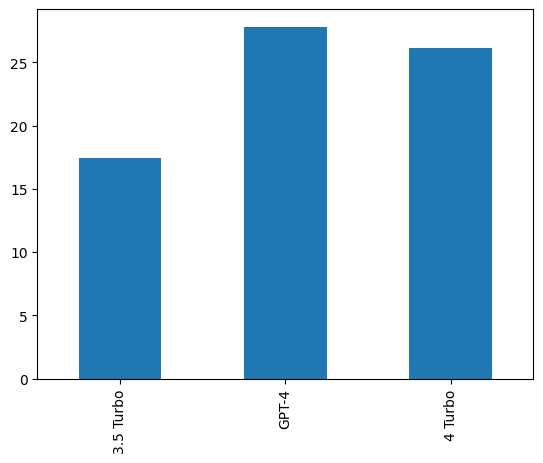

In [16]:
attributes = ['3.5 Turbo', 'GPT-4','4 Turbo']

val_data[attributes].sum().plot.bar()

In [10]:
class Code_Dataset(Dataset):

  def __init__(self, data, tokenizer, attributes, max_token_len: int = 512):
    self.data = data
    self.tokenizer = tokenizer
    self.attributes = attributes
    self.max_token_len = max_token_len
      
  def __len__(self):
      return len(self.data)

  def __getitem__(self, index):
    item = self.data.iloc[index]
    code_sample = str(item.Code)
    attributes = torch.FloatTensor(item[self.attributes])
    tokens = self.tokenizer.encode_plus(code_sample,
                                        add_special_tokens=True,
                                        return_tensors='pt',
                                        truncation=True,
                                        padding='max_length',
                                        max_length=self.max_token_len,
                                        return_attention_mask = True)
    return {'input_ids': tokens.input_ids.flatten(), 'attention_mask': tokens.attention_mask.flatten(), 'labels': attributes}


In [11]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
# model_name = 'roberta-base'
# tokenizer = AutoTokenizer.from_pretrained(model_name)
Code_ds_train = Code_Dataset(train_data, tokenizer, attributes=attributes)
Code_ds_val = Code_Dataset(val_data, tokenizer, attributes=attributes)
Code_ds_test = Code_Dataset(test_data, tokenizer, attributes=attributes)

In [13]:
class Code_Data_Module(pl.LightningDataModule):

    def __init__(self, train_data, val_data, test_data, attributes, batch_size: int = 4, max_token_length: int = 512,  model_name='distilbert-base-uncased'):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.attributes = attributes
        self.batch_size = batch_size
        self.max_token_length = max_token_length
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)


    def setup(self, stage):
        if stage == "train":
            self.train_dataset = Code_Dataset(self.train_data, attributes=self.attributes, tokenizer=self.tokenizer)
            self.val_dataset = Code_Dataset(self.val_data, attributes=self.attributes, tokenizer=self.tokenizer)
        if stage == 'predict':
            self.test_dataset = Code_Dataset(self.test_data, attributes=self.attributes, tokenizer=self.tokenizer)


    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size = self.batch_size, num_workers=4, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size = self.batch_size, num_workers=4, shuffle=False)

    def predict_dataloader(self):
        return DataLoader(self.test_data, batch_size = self.batch_size, num_workers=4, shuffle=False)

In [14]:
Code_dm = Code_Data_Module(train_data, val_data, test_data, attributes)
Code_dm.setup("train")
Code_dm.train_dataloader()
len(Code_dm.train_dataloader())

83

In [17]:
class Code_Classifier(pl.LightningModule):

    def __init__(self, config: dict):
        super().__init__()
        self.config = config
        self.pretrained_model = AutoModel.from_pretrained(config['model_name'], return_dict = True)
        self.hidden = torch.nn.Linear(self.pretrained_model.config.hidden_size, self.pretrained_model.config.hidden_size)
        self.classifier = torch.nn.Linear(self.pretrained_model.config.hidden_size, self.config['n_labels'])
        torch.nn.init.xavier_uniform_(self.classifier.weight)
        self.loss_func = nn.BCEWithLogitsLoss(reduction='mean')
        self.dropout = nn.Dropout()

    def forward(self, input_ids, attention_mask, labels=None):
        # roberta layer
        output = self.pretrained_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = torch.mean(output.last_hidden_state, 1)
        # final logits
        pooled_output = self.dropout(pooled_output)
        pooled_output = self.hidden(pooled_output)
        pooled_output = F.relu(pooled_output)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        # calculate loss
        loss = 0
        if labels is not None:
            loss = self.loss_func(logits.view(-1, self.config['n_labels']), labels.view(-1, self.config['n_labels']))
        return loss, logits
    
    def training_step(self, batch, batch_index):
        loss, outputs = self(**batch)
        self.log("train loss ", loss, prog_bar = True, logger=True)
        return {"loss":loss, "predictions":outputs, "labels": batch["labels"]}
    
    def validation_step(self, batch, batch_index):
        loss, outputs = self(**batch)
        self.log("validation loss ", loss, prog_bar = True, logger=True)
        return {"val_loss": loss, "predictions":outputs, "labels": batch["labels"]}
    
    def predict_step(self, batch, batch_index):
        loss, outputs = self(**batch)
        return outputs
    
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.config['lr'], weight_decay=self.config['weight_decay'])
        total_steps = self.config['train_size']/self.config['batch_size']
        warmup_steps = math.floor(total_steps * self.config['warmup'])
        scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
        return [optimizer],[scheduler]

In [18]:
config = {
    'model_name': 'distilbert-base-uncased',
    'n_labels': len(attributes),
    'batch_size': 4,
    'lr': 1.5e-6,
    'warmup': 0.2, 
    'train_size': len(Code_dm.train_dataloader()),
    'weight_decay': 0.001,
    'n_epochs': 10
}



In [ ]:
Code_dm = Code_Data_Module(train_data, val_data, test_data, attributes)
Code_dm.setup("train")

model = Code_Classifier(config)

trainer = pl.Trainer(max_epochs=config['n_epochs'], num_sanity_val_steps=50)
trainer.fit(model, Code_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\ncool\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
c:\Users\ncool\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warni

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\ncool\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
